## 通过 卷积神经网络 来进行图片分类
通过 CNN 来进行图片识别，目前 CNN 可以说是最好的方法，新的胶囊网络可能会颠覆，所以所有的知识都是会发展的。
### 第一个任务：Dogs vs Cats
数据说明：
25,000 个训练样本

12,500 个测试样本


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "data/dogscats/"
sz=224

下面来校验 gpu 是有可用，我们使用的是 NVidia 的 GPUs -- CUDA

In [7]:
torch.cuda.is_available()

True

另外 NVidia 为深度学习提供了加速包 CuDNN

In [8]:
torch.backends.cudnn.enabled

True

第一步，先来看下数据

In [9]:
os.listdir(PATH)

['valid', 'test1', 'sample', 'models', 'tmp', 'train']

In [10]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [11]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.9107.jpg',
 'cat.8293.jpg',
 'cat.8587.jpg',
 'cat.9138.jpg',
 'cat.2300.jpg']

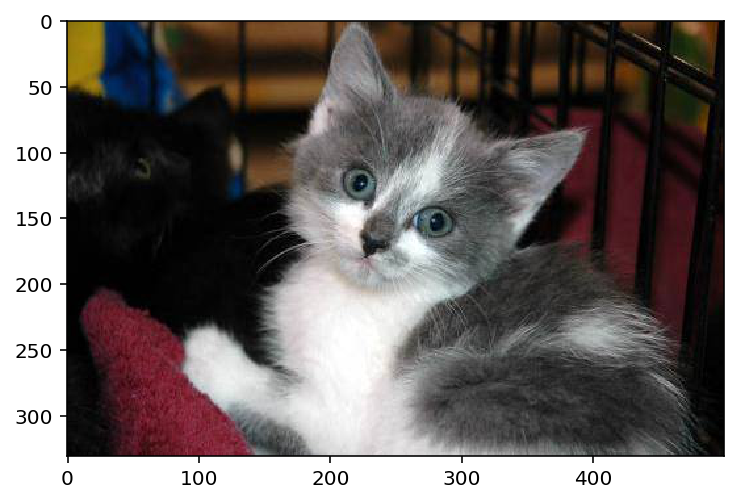

In [12]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

看下原始数据，数组的形式

In [13]:
img.shape

(331, 500, 3)

In [14]:
img[:4,:4]

array([[[136, 111,  11],
        [136, 111,  11],
        [137, 112,  11],
        [139, 114,  13]],

       [[136, 111,  11],
        [137, 112,  12],
        [138, 113,  12],
        [139, 114,  13]],

       [[137, 112,  12],
        [138, 113,  12],
        [139, 114,  13],
        [140, 115,  14]],

       [[138, 113,  12],
        [138, 113,  12],
        [139, 114,  13],
        [141, 116,  15]]], dtype=uint8)

## 第一个模型
我们第一个模型使用 resnet34 ，2015 ImageNet 大赛的冠军，模型的详细信息[resnet models](https://github.com/KaimingHe/deep-residual-networks)

In [15]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.042234   0.028476   0.98877   
    1      0.043735   0.027413   0.989746                     



[0.027413, 0.98974609375]

## 结果分析
下面分析一下结果

1. 正确的
2. 错误的
3. 最正确的（正确分类概率值最大）
4. 最错误的（错误分类概率值最大）
5. 最模棱两可的（0.5的概率）


In [16]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
np.shape(data.val_y)

(2000,)

In [18]:
# 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [19]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [20]:
log_preds[:10]

array([[ -0.00002, -10.79545],
       [ -0.00485,  -5.3316 ],
       [ -0.00007,  -9.60679],
       [ -0.00548,  -5.20925],
       [ -0.     , -12.46346],
       [ -0.00002, -10.71904],
       [ -0.0001 ,  -9.17694],
       [ -0.00003, -10.42694],
       [ -0.00528,  -5.24558],
       [ -0.00003, -10.48878]], dtype=float32)

In [21]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [22]:
# ?np.random.choice
# choice(a, size=None, replace=True, p=None)
# ?np.where
# where(condition, [x, y]), 如果只有condition，返回满足的下标 (array(行),array(列))
# np.where(mask)[0] 返回满足的行
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [47]:
# ImageClassifierData 是一类定义的数据结构
data

In [54]:
data.val_ds[1][0].shape

(3, 224, 224)

In [55]:
?np.stack

In [23]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [25]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [45]:
np.random.choice( np.where((preds == data.val_y)==True)[0], 4,replace=False)

array([ 618,   17, 1824, 1114])

Correctly classified


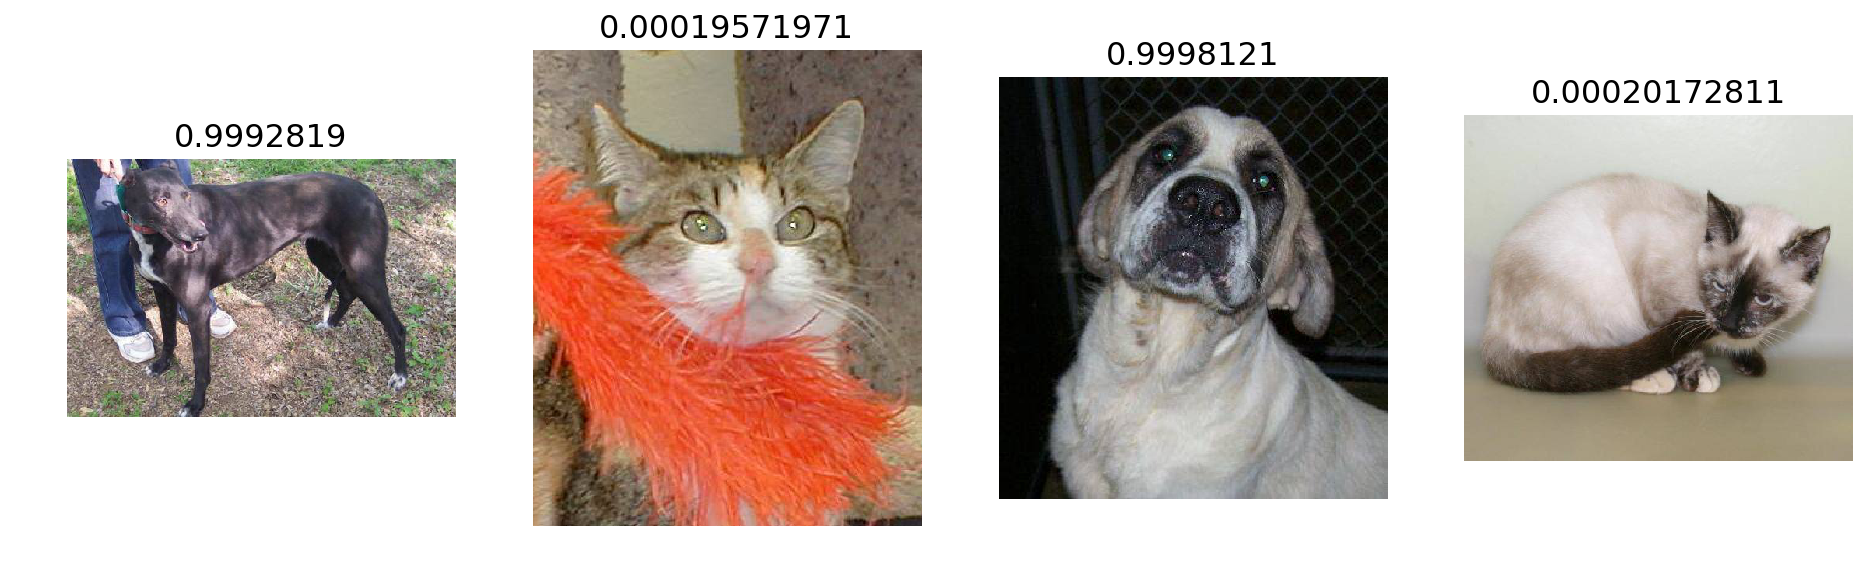

In [46]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


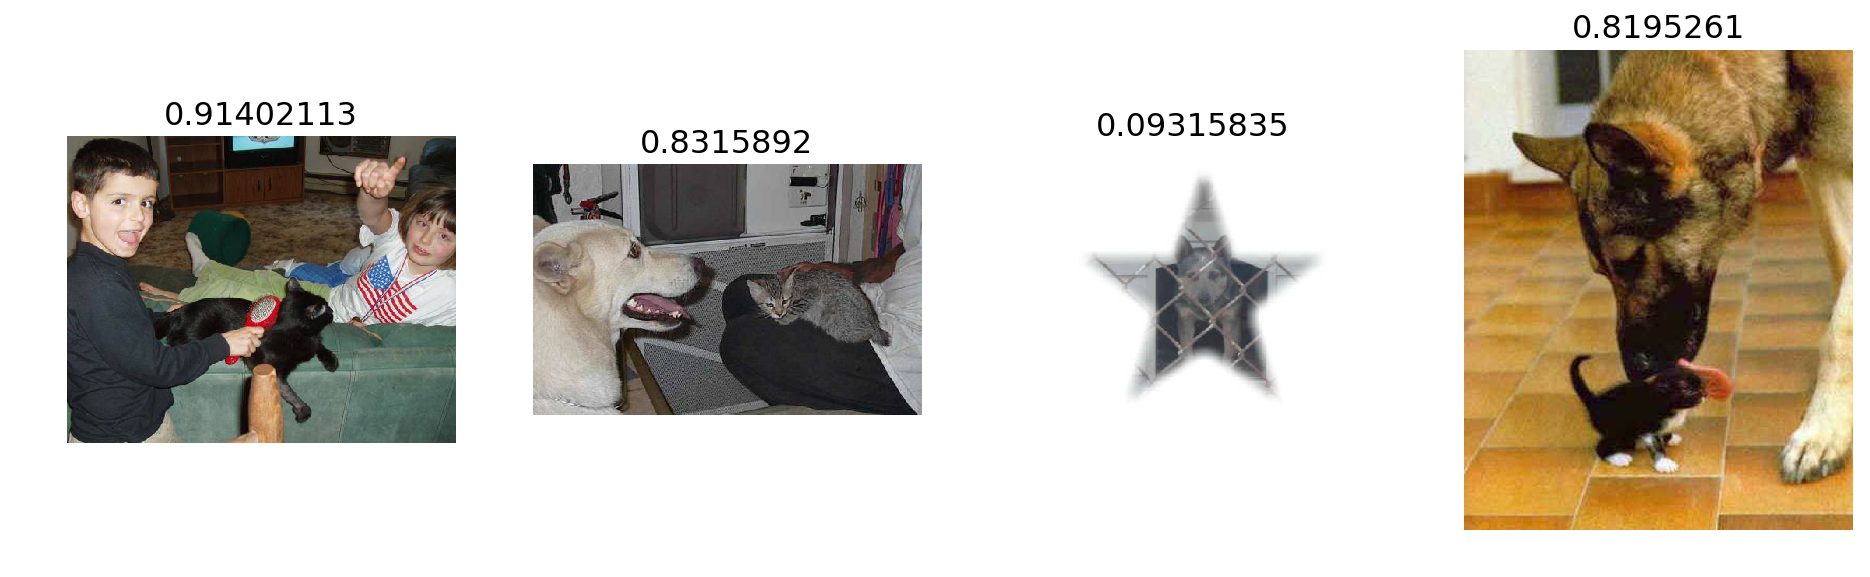

In [56]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [57]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


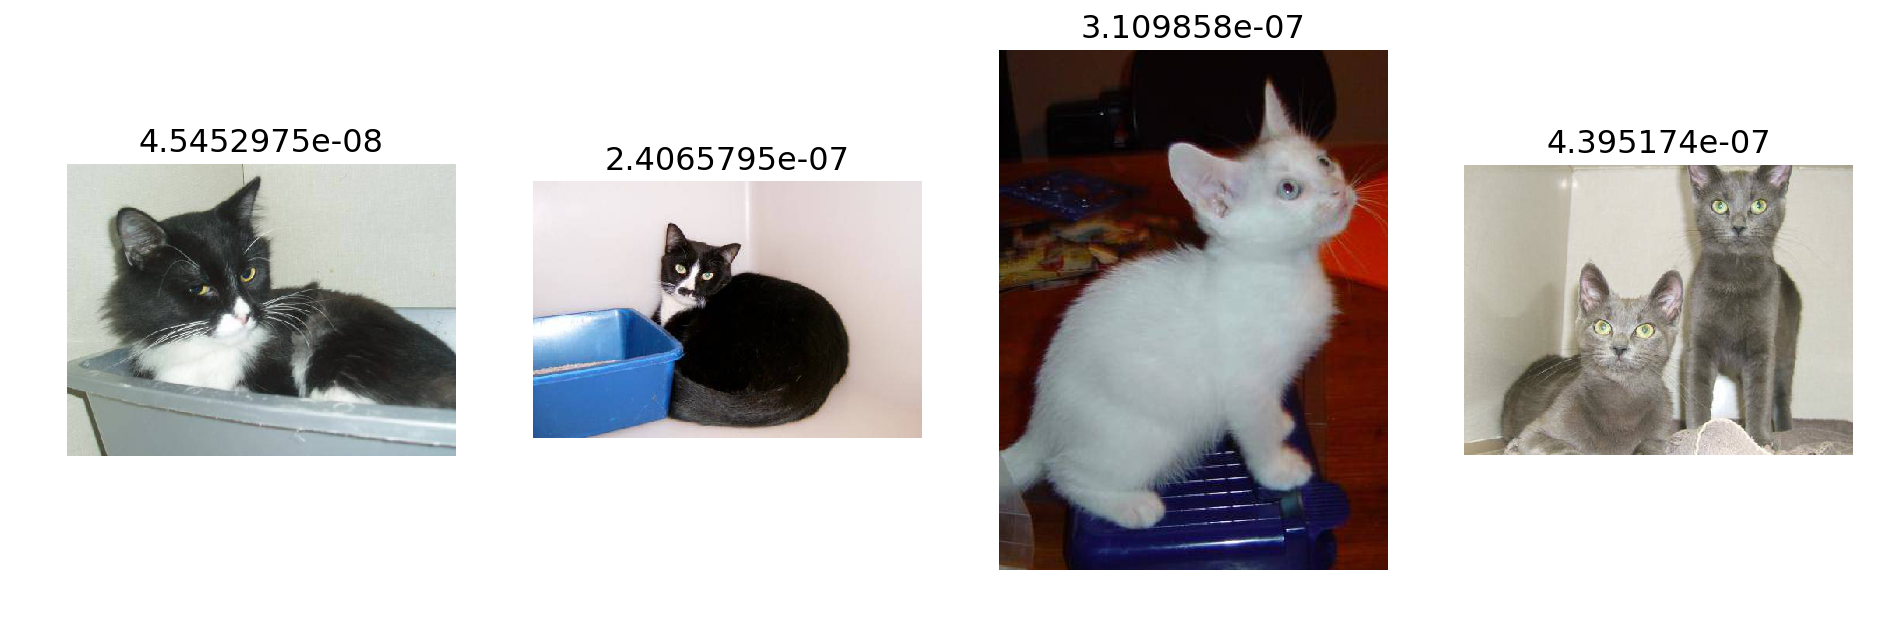

In [58]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


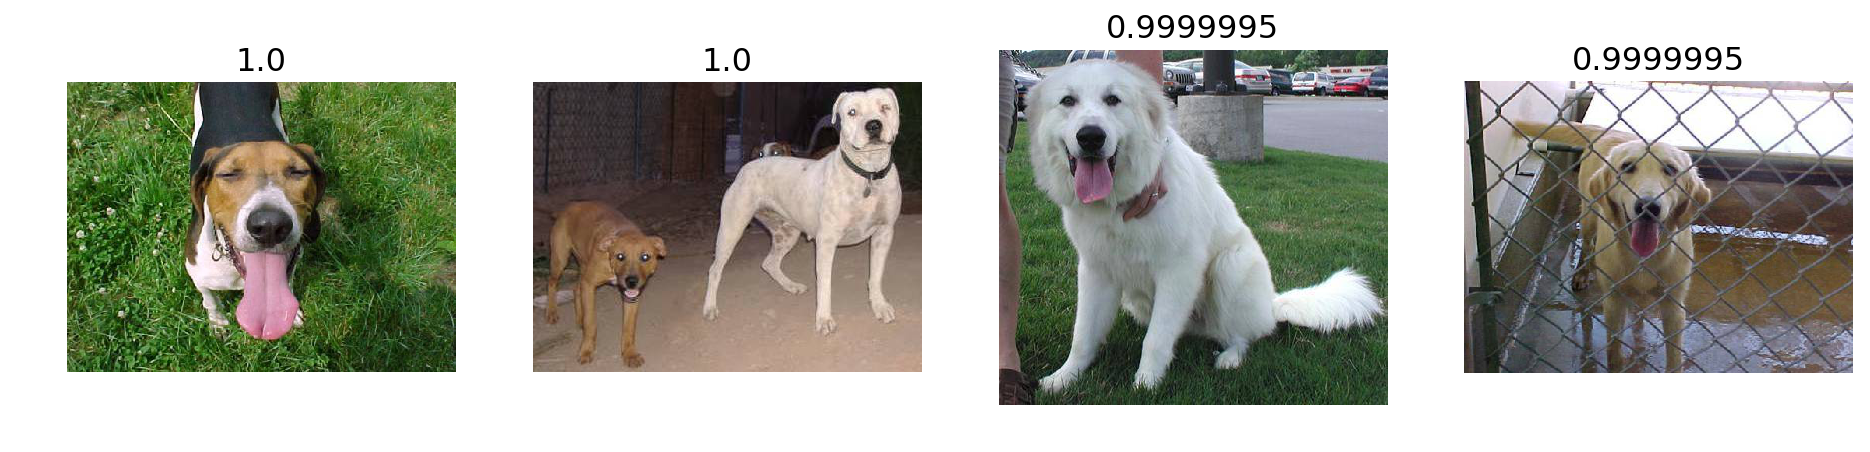

In [59]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


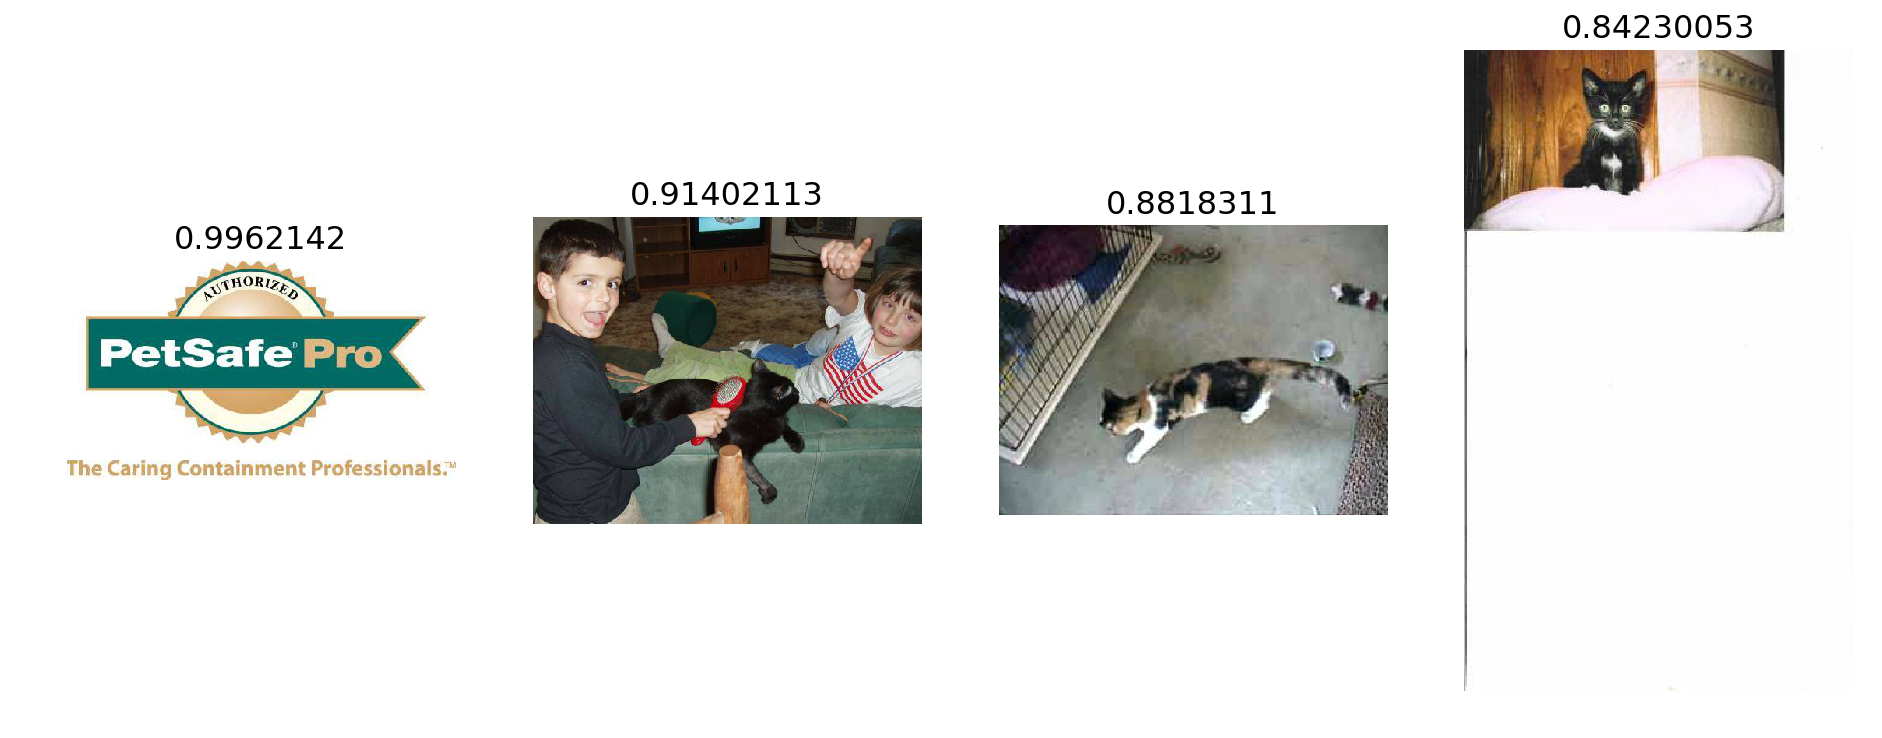

In [60]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


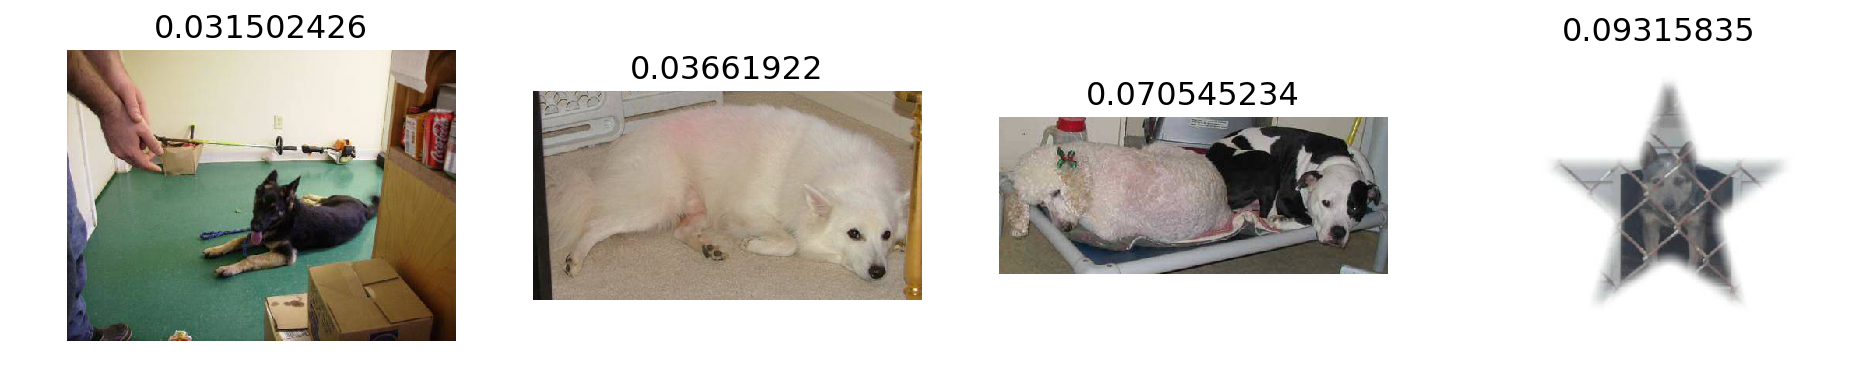

In [61]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


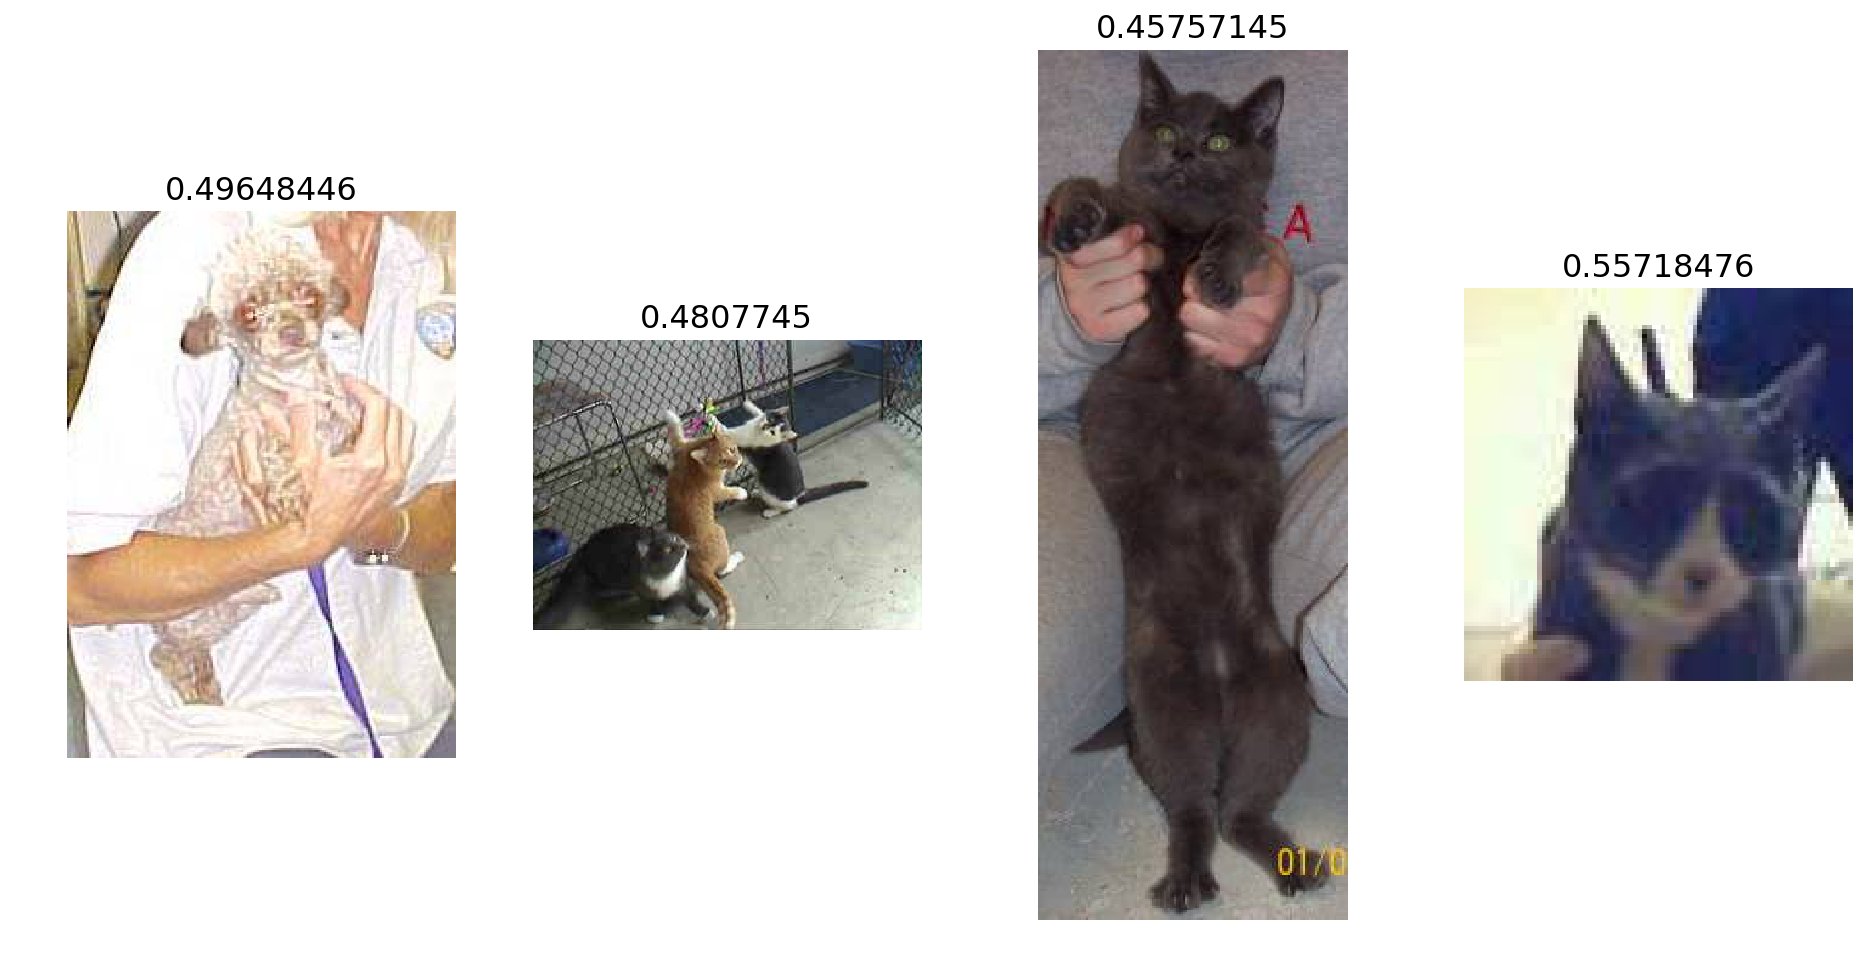

In [62]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## 如何选择 学习率
学习率是一个非常重要的参数，学习率选择太大，可能震荡，太小又会收敛太慢，因此我们需要有方法来选择合适的学习率。

fastai中选择学习率的方法来自[Cyclical Learning Rates for Training Neural Networks](https://www.zybuluo.com/zhuanxu/note/1014851)

In [63]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [66]:
# 找到最佳的 lr
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 279/360 [00:09<00:02, 30.27it/s, loss=0.434]


上面279/360中，360是怎么算出来的？360 = 23000/ 64(batch size)

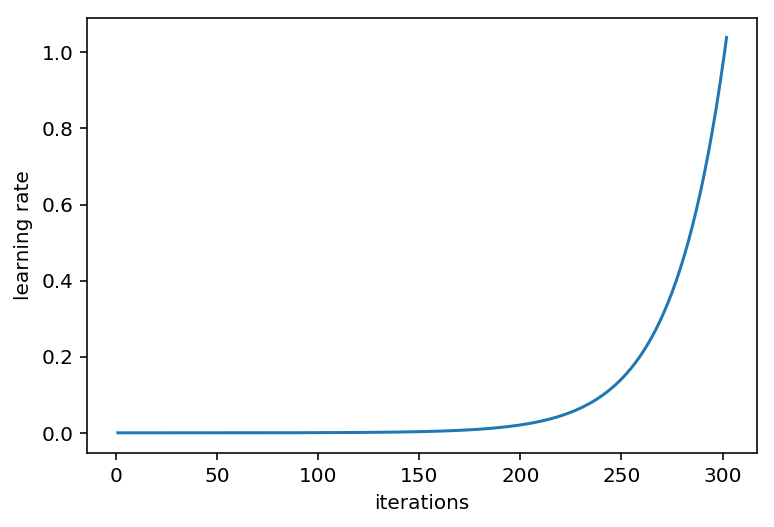

In [73]:
learn.sched.plot_lr()

上图中一个 iteration 是一次SGD，一次SGD是指一个minibatch。

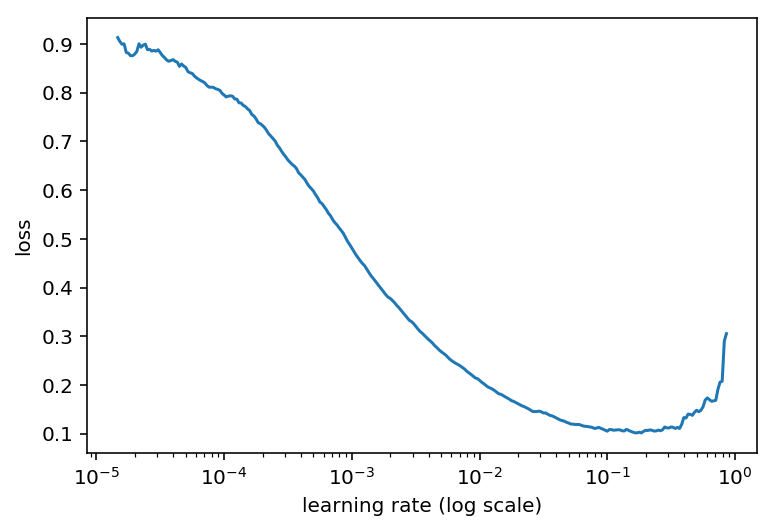

In [74]:
learn.sched.plot()

上图随着 lr 的变化，loss的变化，可以看到 lr=0.01的时候，loss还是在减小的，因此我们选择 lr=0.02

## 提高模型
我们通过数据增强的方式来提高模型，通过对原图进行一些变化

In [75]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [76]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [77]:
ims = np.stack([get_augs() for i in range(6)])

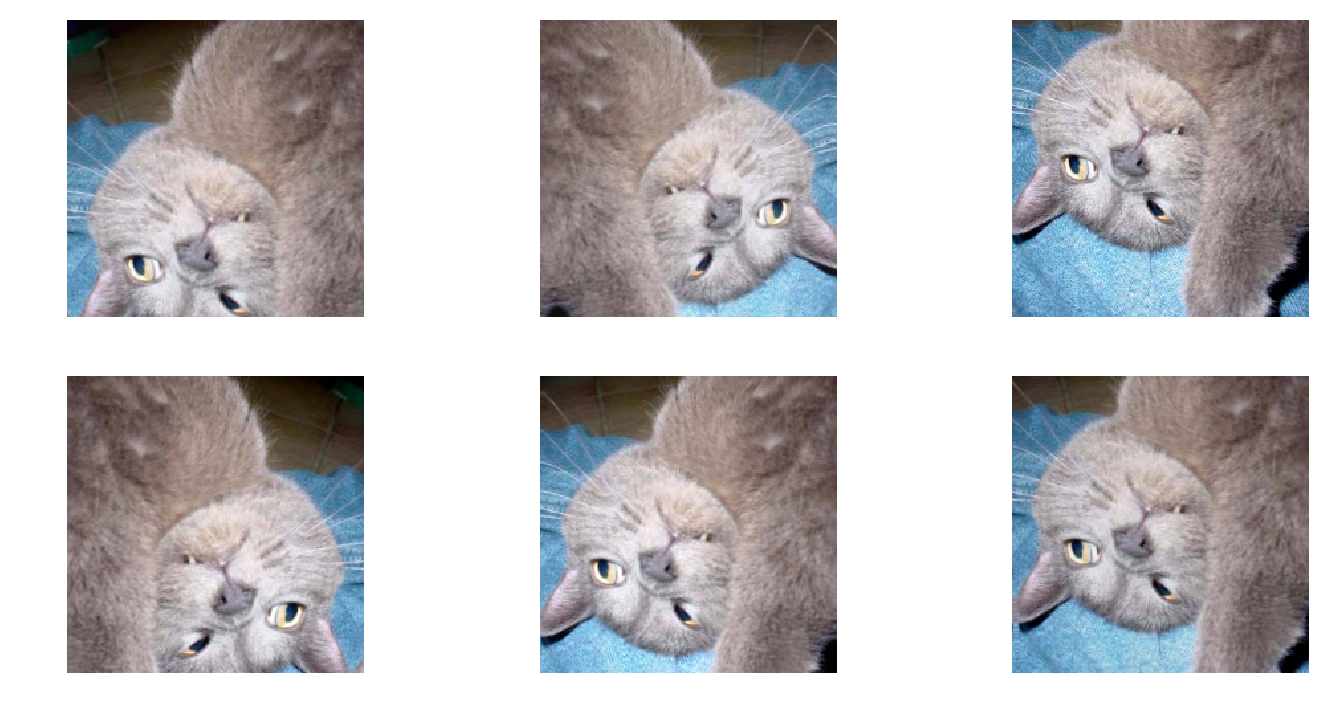

In [78]:
plots(ims, rows=2)

In [79]:
# 下面我们重新训练模型
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [80]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.043469   0.024399   0.993164  



[0.02439879, 0.9931640625]

In [81]:
# 通过设置 precompute = False ，我们让整个卷积网络都不可改变
learn.precompute=False

In [83]:
# cycle_len=1 让 lr 在每个 epoch 后都重置
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.047875   0.023554   0.991211  
    1      0.045183   0.024196   0.992676                     
    2      0.038574   0.02513    0.990723                     



[0.025130216, 0.99072265625]

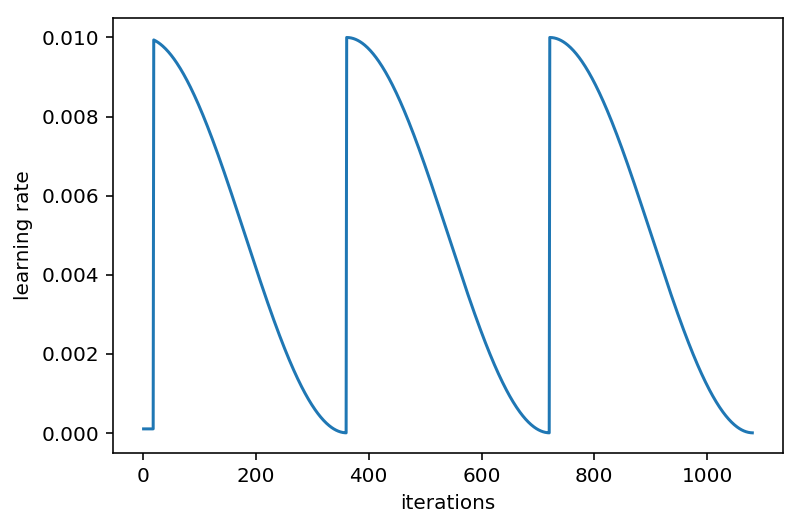

In [84]:
learn.sched.plot_lr()

我们可以看到 lr的变化是周期性的，每个epoch重置一次，变化是按照 cosin 递减

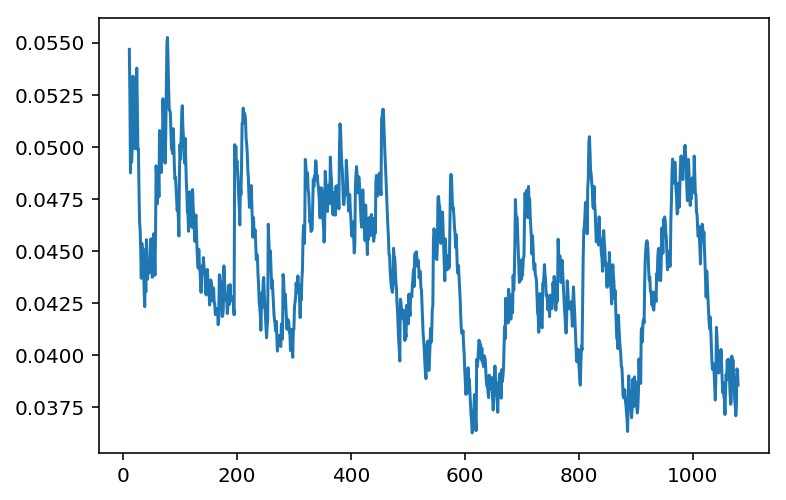

In [86]:
learn.sched.plot_loss()

In [87]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

## 微调 以及 不同的学习率
我们在上面已经在最后一层调试好了，下面我们要开始去调试其他层参数，frozen_layer 为之前的卷积层

In [88]:
learn.unfreeze()

在整个卷积层中，于是靠近输入数据的卷积层，其捕获的特征就越精细，因此我们在训练上越是前面的层其微调就越小，因此对不同卷积层我们采用不同的学习率，将这种方法叫做: **differential learning rates**

In [89]:
lr=np.array([1e-4,1e-3,1e-2])

In [90]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.052042   0.022158   0.993652  
    1      0.040674   0.021632   0.992188                     
    2      0.025974   0.02035    0.991211                     
    3      0.029177   0.021256   0.991211                     
    4      0.029576   0.021434   0.993164                     
    5      0.017794   0.018174   0.994629                     
    6      0.016429   0.018269   0.993652                     



[0.018268675, 0.99365234375]

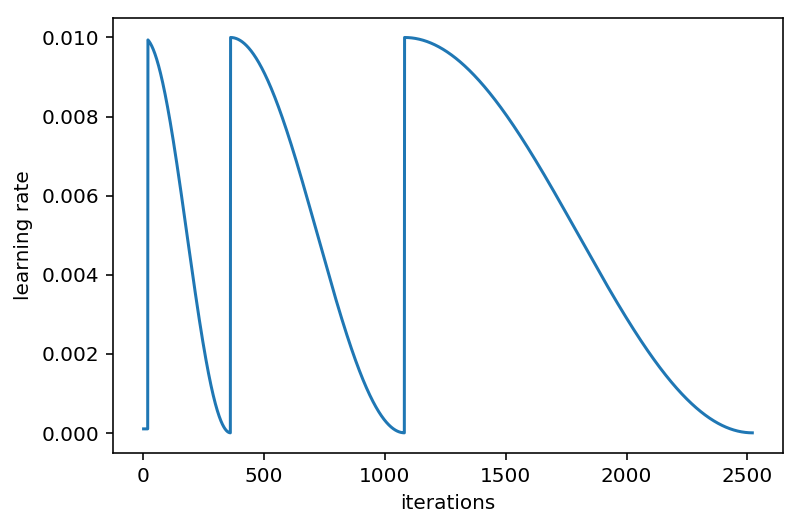

In [92]:
# 可以看到上面的数据，其实已经开始过拟合了。因为 val_loss 已经开始大于 trn_loss 了
learn.sched.plot_lr()

通过上图我们知道了 cycle_mult=2 的作用是每次重置lr都是之前的2倍cycle

## TTA
什么是tta呢？test time augmentation，即我们之前在训练的时候对数据进行了增强，我们将这个方法也用到预测过程中，将要预测的数据进行增强，分别进行预测，然后再将结果进行平均

In [93]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [94]:
accuracy_np(probs, y)

0.996

我们可以看到，通过简单的TTA，我们进一步提升了准确率

## 结果分析
我们采用[混淆矩阵](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)的方法来分析结果

In [95]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  3 997]]


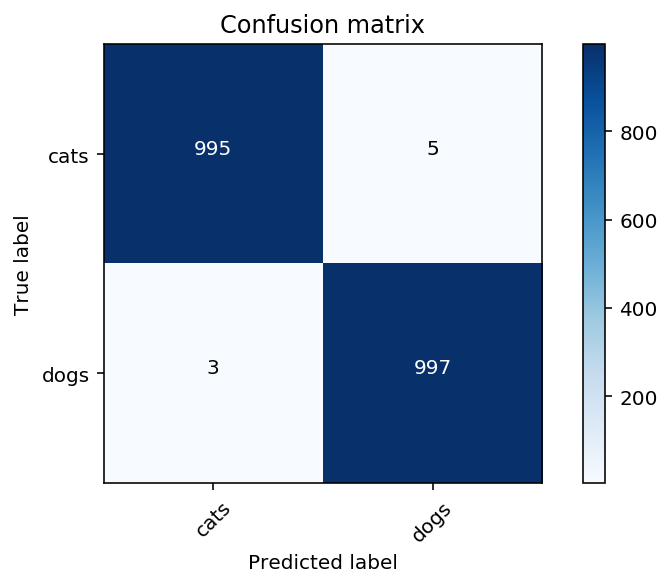

In [97]:
plot_confusion_matrix(cm, data.classes)

我们发现只有8个数据判断错了，大多都是正确的。

我们再来分析下数据

Most incorrect cats


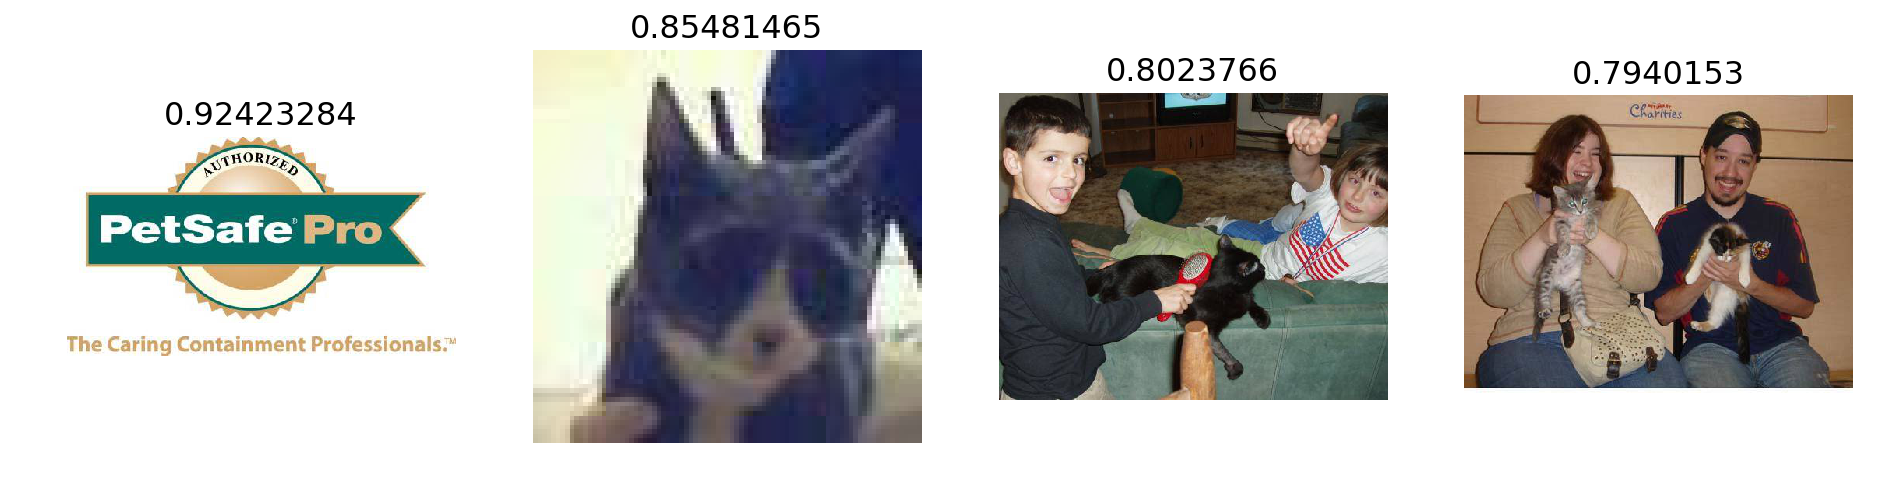

In [98]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


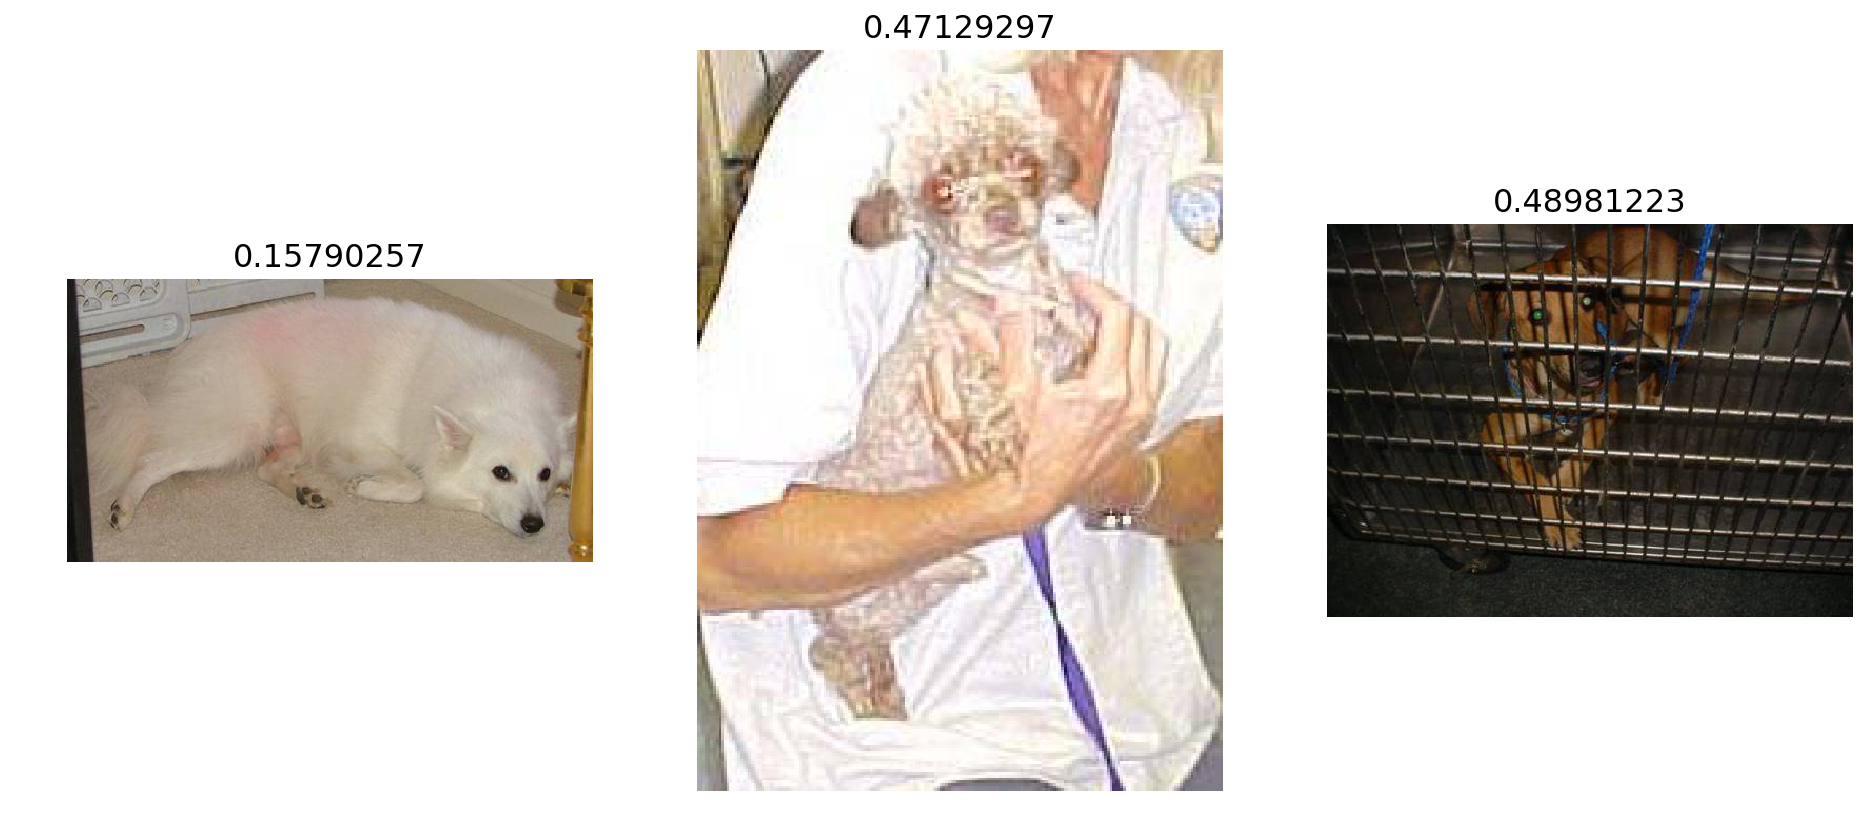

In [99]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## 训练步骤总结
1. 开始数据增强功能，设置precompute=True
2. 使用 lr_find() 方法来寻找最大的 learning rate，在此 lr 下，还能显著的降低 loss
3. 使用预训练的模型来训练模型最后一层，大概 1-2 epoches
4. 使用lr变化的方法来训练最后一层，大概 2-3 epoches
5. 解锁所有卷积层
6. 通过 differential learning rates 来训练网络
7. 再次使用 lr_find()
8. 设置 cycle_mult=2 再次训练整个网络，直到过拟合

## 深入理解我们第一个模型
tfms 是 transformations 的缩写，tfms_from_model 能够帮助我们对图片进行 缩放、裁剪、正则化。



In [101]:
# sz = 224, resnet34,<function torchvision.models.resnet.resnet34>
tfms = tfms_from_model(resnet34, sz)

下一步我们需要指定数据路径，ImageClassifierData.from_paths 从指定的路径去读取数据，并且创建一个数据结构，方便后续的训练

In [104]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

下一步我们需要用对模型训练，我们加载如预训练的模型参数，然后只对模型的最后一层进行微调：
![](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

我们将上图中的FC8替换为只有2个输出的层

In [105]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

上面我们传入数据，整个模型通过传入的数据来学习模型参数，一般lr是一个非常重要的参数，通常设置0.01，0.001是一个不错的选择

In [106]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.053037   0.028221   0.990723  



[0.028220784, 0.99072265625]

以上就是本次课程的全部